### Autor: Fernando Ordinola

## Preliminares

> __Formulación del problema__:  La data disponible cuenta con diversas y múltiples variables relacionadas con atributos que pueden determinar, en cierta medida, la desigualdad de ingreso y la pobreza extrema. No se sabe cuáles pueden explicar en mayor o menor medida nuestra variable de interés, tampoco se cuenta con un modelo que pueda predecir con un nivel óptimo de significancia para ejecutar soluciones no reactivas al problema socioeconómico.
>
> __Objetivos__: El objetivo principal de este proyecto es desarrollar un modelo predictivo capaz de detectar la probabilidad de que un individuo reciba un salario por debajo o por encima de los 50,000 dólares a partir de variables sociodemográficas.
>
>
>__Objetivos especificos:__
>> - Recodificar variables.
>> - Procesar la data disponible para usarla en el entrenamiento de un algoritmo de regresión.
>> - Dividir el dataset para entrenamiento
>
>
> __Implementación del modelo__: Se usará un modelo de regresión logística, ya que deseamos clasificar a los individuos en dos categorías: aquellos que tienen un salario por encima o por debajo de los 50,000 dólares. No se usó un modelo de regresión lineal, ya que este no es adecuado para predecir variables binarias. En lugar de eso, se busca predecir la probabilidad de un evento.

> __Métricas de desempeño__
>> - Exactitud
>> - Precisión
>> - Recall
>> - F1 Score
>> - ROC curve, AUC 

## Aspectos Computacionales

> Librerías a utilizar
> - pandas
> - numpy
> - matplotlib
> - statsmodel
> - seaborn
> - warnings
> - sklearn

> Módulo propio con funciones utilitarias: __functions.py__

# Descripción

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import functions as pyfunc
import warnings
import statsmodels.formula.api as smf
import functions as pyfunc

warnings.filterwarnings(action="ignore")
plt.style.use('seaborn')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score

In [2]:
df = pd.read_csv('income-db.csv').drop('fnlwgt', axis=1)

In [3]:
df

,age,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
48838,40,Private,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
48839,58,Private,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
48840,22,Private,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [4]:
df = df.replace('?', np.nan)

In [5]:
master_dict = {
    'collars' : {'white_collar': ['Prof-specialty', 'Exec-managerial', 'Adm-clerical', 'Sales', 'Tech-support'],
                       'blue_collar': ['Craft_Repair', 'Machine-op-inspct', 'Transport-moving', 'Handlers-cleaners', 
                                       'Farming-fishing', 'Protective-serv', 'Priv-house-serv'],
                       'others': ['Other-service', 'Armed-Forces']},

    'workclass_recod': {'federal_gov': 'Federal-gov', 'state-level-gov': ['State-gov', 'Local-gov'], 
                       'self_employed': ['Self-emp-inc', 'Self-emp-not-inc'], 'unemployed': ['Never-worked', 'Without-pay']},

    'educ_recod': {'preschool': 'Preschool', 'elementary_school': ['1st-4th', '5th-6th'], 
                  'high_school': ['7th-8th', '9th', '10th', '11th', '12th', 'HS-grad'],
                 'college': ['Assoc-voc', 'Assoc-acdm', 'Some-college'],
                 'university': ['Bachelors','Masters', 'Prof-school', 'Doctorate']},

    'civstatus': {'married': ['Married-civ-spouse', 'Married-spouse-absent', 'Married-AF-spouse'],
                    'divorced': 'Divorced', 'separated': 'Separated', 'widowed': 'Widowed'}}

In [6]:
for recod in master_dict:
    for recod_ in master_dict[recod]:
        df = df.replace(to_replace=master_dict[recod][recod_], value=recod_)

In [7]:
new_columns_names = {'occupation':'collars', 'workclass': 'workclass_recod', 'education': 'educ_recod', 
                     'marital-status': 'civstatus', 'native-country': 'region'}
        
df.rename(columns = new_columns_names, inplace = True)

In [8]:
country_continents = {
    'America': ['United-States', 'Mexico', 'Canada', 'Puerto-Rico', 'Cuba', 'Guatemala', 'Nicaragua', 'Peru', 'Ecuador',
               'Haiti', 'El-Salvador', 'South', 'Jamaica', 'Dominican-Republic', 'America', 'Trinadad&Tobago', 
                'Outlying-US(Guam-USVI-etc)', 'Honduras', 'Columbia'],
    
    'Asia': ['Philippines','China','Vietnam', 'Japan', 'India', 'Taiwan', 'Iran', 'Hong', 'Thailand', 'Cambodia', 'Laos'],
    'Oceania': [],
    
    'Europa': ['Germany', 'England', 'Italy', 'Yugoslavia', 'France', 'Ireland', 'Taiwan', 'Poland', 'Portugal', 'Greece',
              'Scotland', 'Hungary', 'Holand-Netherlands'],
    
    'Africa': []
}

In [9]:
for continent in country_continents:
    df = df.replace(to_replace=country_continents[continent], value=continent)

In [10]:
df['region'].value_counts()

America    46224
Asia         981
Europa       780
Name: region, dtype: int64

In [11]:
df = pd.get_dummies(df, drop_first=True)

In [12]:
#Se creó este procesamiento de datos para que las variables pudieran ser utilizadas por el modelo descriptivo.
#se reemplazó - por _ en el nombre de las variables
df.rename(columns = {column: column.replace('-', '_') for column in df.columns}, inplace = True) 

In [13]:
df.columns

Index(['age', 'educational_num', 'capital_gain', 'capital_loss',
       'hours_per_week', 'workclass_recod_federal_gov',
       'workclass_recod_self_employed', 'workclass_recod_state_level_gov',
       'workclass_recod_unemployed', 'educ_recod_elementary_school',
       'educ_recod_high_school', 'educ_recod_preschool',
       'educ_recod_university', 'civstatus_divorced', 'civstatus_married',
       'civstatus_separated', 'civstatus_widowed', 'collars_blue_collar',
       'collars_others', 'collars_white_collar', 'relationship_Not_in_family',
       'relationship_Other_relative', 'relationship_Own_child',
       'relationship_Unmarried', 'relationship_Wife',
       'race_Asian_Pac_Islander', 'race_Black', 'race_Other', 'race_White',
       'gender_Male', 'region_Asia', 'region_Europa', 'income_>50K'],
      dtype='object')

In [14]:
df

,age,educational_num,capital_gain,capital_loss,hours_per_week,workclass_recod_federal_gov,workclass_recod_self_employed,workclass_recod_state_level_gov,workclass_recod_unemployed,educ_recod_elementary_school,...,relationship_Unmarried,relationship_Wife,race_Asian_Pac_Islander,race_Black,race_Other,race_White,gender_Male,region_Asia,region_Europa,income_>50K
0,25,7,0,0,40,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
1,38,9,0,0,50,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
2,28,12,0,0,40,0,0,1,0,0,...,0,0,0,0,0,1,1,0,0,1
3,44,10,7688,0,40,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1
4,18,10,0,0,30,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,12,0,0,38,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
48838,40,9,0,0,40,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,1
48839,58,9,0,0,40,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
48840,22,9,0,0,20,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0


In [15]:
df.describe()

,age,educational_num,capital_gain,capital_loss,hours_per_week,workclass_recod_federal_gov,workclass_recod_self_employed,workclass_recod_state_level_gov,workclass_recod_unemployed,educ_recod_elementary_school,...,relationship_Unmarried,relationship_Wife,race_Asian_Pac_Islander,race_Black,race_Other,race_White,gender_Male,region_Asia,region_Europa,income_>50K
count,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,...,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.00000,48842.000000
mean,38.643585,10.078089,1079.067626,87.502314,40.422382,0.029319,0.113775,0.104766,0.000635,0.015478,...,0.104930,0.047725,0.031100,0.095922,0.008313,0.855043,0.668482,0.020085,0.01597,0.239282
std,13.710510,2.570973,7452.019058,403.004552,12.391444,0.168701,0.317541,0.306255,0.025186,0.123447,...,0.306467,0.213187,0.173591,0.294487,0.090794,0.352061,0.470764,0.140293,0.12536,0.426649
min,17.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.00000,0.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.00000,0.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


### Inspección visual de vector objetivo

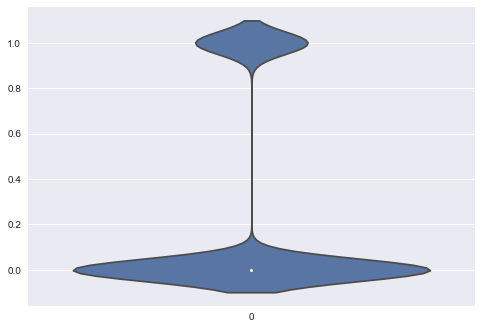

In [16]:
sns.violinplot(data=df['income_>50K']);
#La proporción de individuos que tienen un salario anual mayor a 50,000 dólares es significativamente inferior.

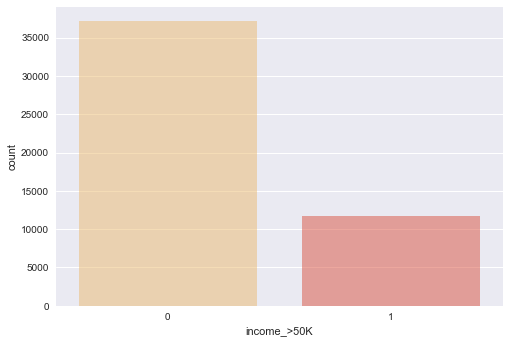

In [17]:
sns.countplot(x=df['income_>50K'], palette="YlOrRd", alpha=.5);

La cantidad de datos está más concentrada en individuos que ganan menos del umbral, por lo que es posible que el modelo aprenda mejor a predecir a individuos que están por debajo del umbral.

### Inspección visual de las variables

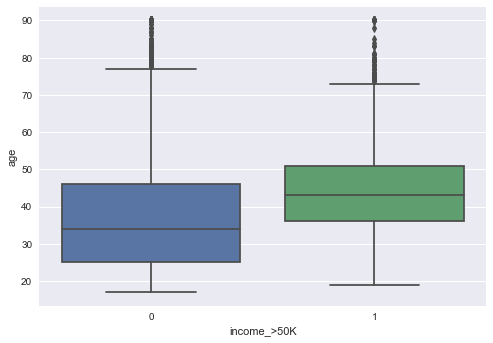

In [18]:
sns.boxplot(data=df, x='income_>50K', y="age");

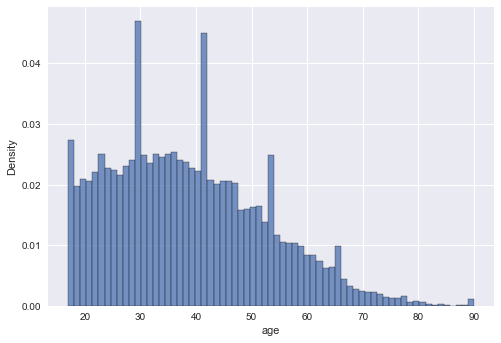

In [19]:
sns.histplot(data=df, x='age', stat='density', common_norm=False);

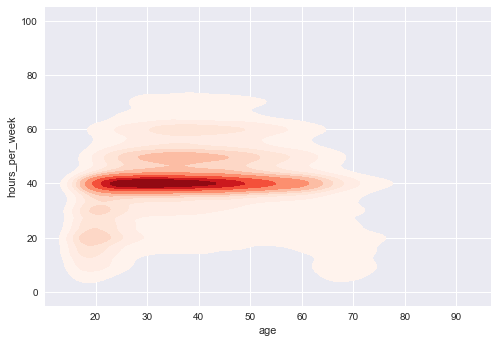

In [20]:
sns.kdeplot(data=df, x='age',y="hours_per_week", cmap='Reds', shade=True);

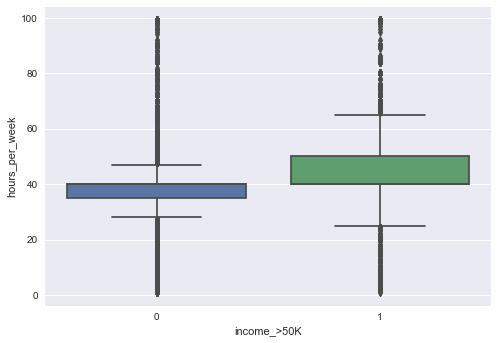

In [21]:
sns.boxplot(data=df, x='income_>50K', y="hours_per_week");
#gran presencia de outliers.

La gran cantidad de valores atípicos en las horas trabajadas por semana puede ser indicativa de que estos datos pertenecen a una población diferente del resto de los datos que se encuentran dentro de las cajas del diagrama de cajas.

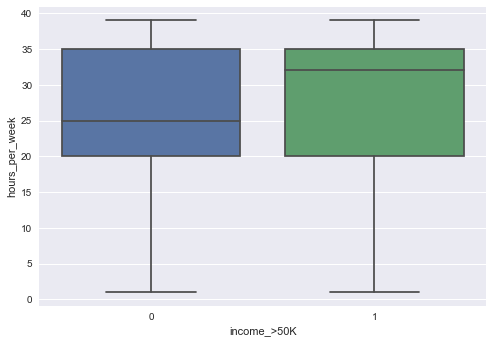

In [22]:
sns.boxplot(data=df[df["hours_per_week"] < np.quantile(df["hours_per_week"], 0.5)], x='income_>50K', y="hours_per_week");

Es decir, parece haber una mayor dispersion de horas trabajadas por semana en los individuos que ganan más de 50 mil dólares anuales por debajo de la mediana, mientras que los que ganan menos del umbral tienen una mayor dispersion por encima de la mediana. Esto podría ser un indicio de que el número de horas trabajadas por semana podría ser una variable relevante a la hora de predecir el salario de un individuo.

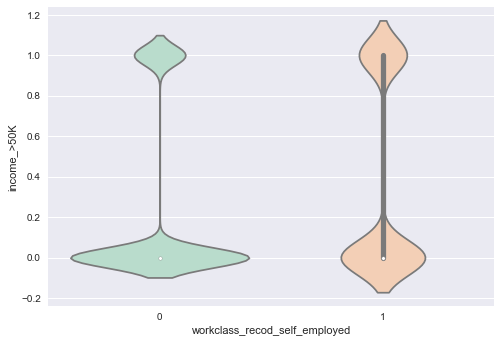

In [23]:
sns.violinplot(x='workclass_recod_self_employed', y="income_>50K", data=df, palette="Pastel2");

Se puede observar que los individuos que son trabajadores por cuenta propia, están distribuidos de forma más pareja en comparación con los que no lo son. La representación sugiere que hay mayor cantidad de individuos que ganan por debajo del umbral correspondientes a los que trabajan de forma dependiente.


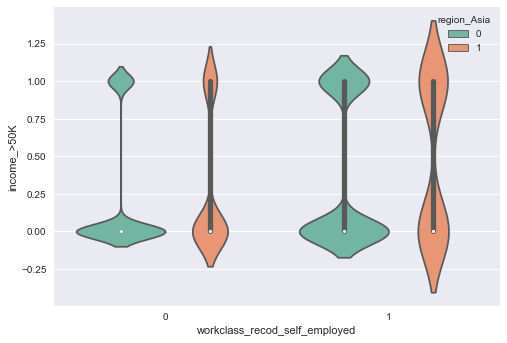

In [24]:
sns.violinplot(x='workclass_recod_self_employed', y="income_>50K", hue='region_Asia', data=df,
              palette="Set2");

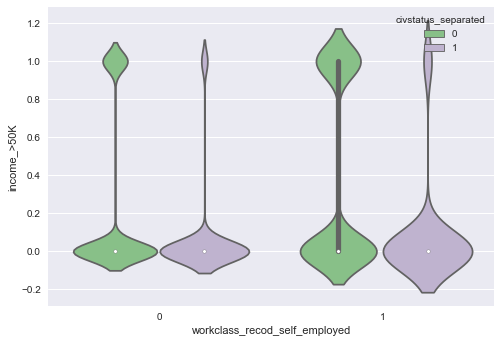

In [25]:
sns.violinplot(x='workclass_recod_self_employed', y="income_>50K", hue='civstatus_separated', data=df,
              palette="Accent");

Es notable que la mayoría de los individuos separados ganan menos de 50 mil dólares al año, independientemente de si trabajan por cuenta propia o no. Sin embargo, es más común encontrar a separados que trabajan por cuenta propia y ganan menos del umbral que a aquellos que no lo son.

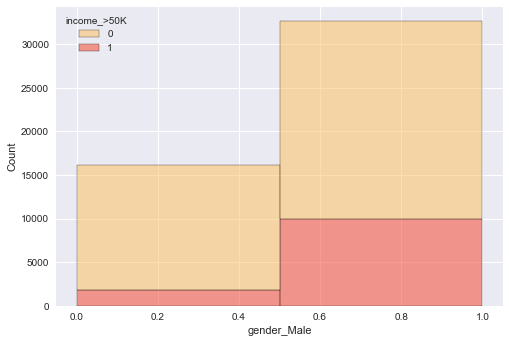

In [26]:
sns.histplot(binwidth=0.5, x="gender_Male", hue="income_>50K", data=df, stat="count", multiple="stack",
            alpha=.5, palette="YlOrRd");

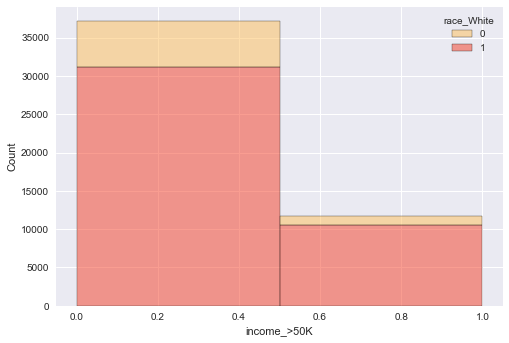

In [27]:
sns.histplot(binwidth=0.5, hue="race_White", x="income_>50K", data=df, stat="count", multiple="stack", 
             alpha=.5, palette="YlOrRd");

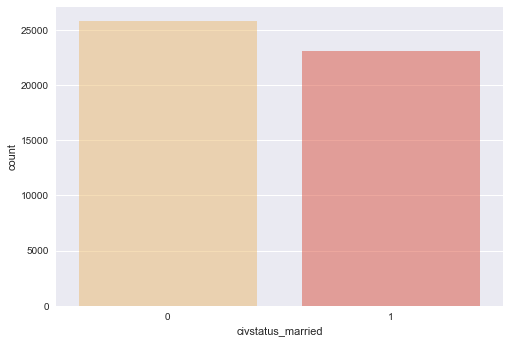

In [28]:
sns.countplot(x=df['civstatus_married'], palette="YlOrRd", alpha=.5);

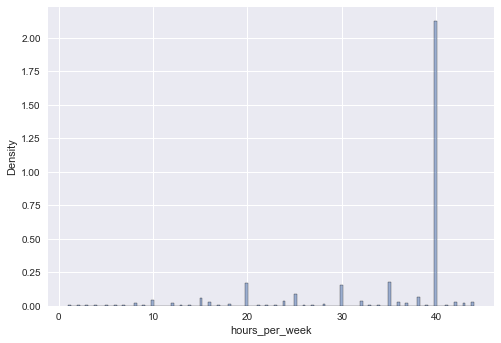

In [29]:
sns.histplot(x="hours_per_week", data=df[df["hours_per_week"] < np.quantile(df["hours_per_week"], 0.75)], 
             palette="YlOrRd", alpha=.5, stat='density', common_norm=False);

### Inspección de datos perdidos en las variables

In [30]:
pyfunc.plot_nas(df)

No hay Datos Nulos encontrados


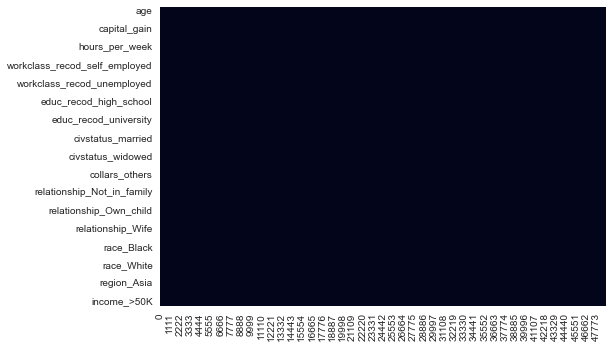

In [31]:
sns.heatmap(df.isnull().transpose(), cbar=False, cbar_kws={'label': 'Missing Data'});

# Modelación descriptiva

In [32]:
df.rename(columns = {'income_>50K': 'more_than_50_t'}, inplace = True)

La función "get_best_model_OLS" se utiliza para crear un modelo y luego iterar sobre él hasta que todas las variables independientes tengan un pvalue menor al especificado. Esto se hace con el fin de obtener un modelo limpio y eficiente, con el que se puedan realizar predicciones precisas. Además, la función también proporciona una tabla de resumen de los diferentes modelos que iteró, con sus métricas correspondientes, lo que facilita la comparación y análisis de los mismos.

In [33]:
logit_full, summary_table = pyfunc.get_best_model_L(df, 'more_than_50_t', ['more_than_50_t'], 0.05)

Optimization terminated successfully.
         Current function value: 0.324198
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.324360
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.324378
         Iterations 9


In [34]:
summary_table #la función también se hizó que entregará una tabla de resumen de los modelos en los que iteró.

,Model,Pseudo R- Squared,LL-Null,Log-Likelihood,LLR P-Value,Variables Indp.,Cant. Variables Mayor a pvalue0.05
0,model1,0.411,-26875.340736,-15834.465637,0.0,32,9
1,model2,0.411,-26875.340736,-15842.376681,0.0,23,1
2,model3,0.410,-26875.340736,-15843.287629,0.0,22,0


In [35]:
logit_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         more_than_50_t   No. Observations:                48842
Model:                          Logit   Df Residuals:                    48819
Method:                           MLE   Df Model:                           22
Date:                Sun, 25 Dec 2022   Pseudo R-squ.:                  0.4105
Time:                        22:26:09   Log-Likelihood:                -15843.
converged:                       True   LL-Null:                       -26875.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -8.2836      0.188    -43.993      0.000      -8.653      -7.915
age                               0.0229      0.001     18.069      0.000       0.020       0.025
educational_num                   0.2889      0.007     42.345      0.000       0.276       0.302
capital_gain                      0.0003   8.33e-06     37.945      0.000       0.000       0.000
capital_loss                      0.0007   2.97e-05     21.944      0.000       0.001       0.001
hours_per_week                    0.0308      0.001     24.564      0.000       0.028       0.033
workclass_recod_federal_gov       0.4790      0.073      6.518      0.000       0.335       0.623
workclass_recod_self_employed    -0.3083      0.041     -7.546      0.000      -0.388      -0.228
civstatus_divorced                0.4958      0.071      7.022      0.000       0.357       0.634
civstatus_married                 1.2636      0.131      9.668      0.000       1.007       1.520
civstatus_separated               0.4246      0.133      3.195      0.001       0.164       0.685
civstatus_widowed                 0.5368      0.128      4.189      0.000       0.286       0.788
collars_blue_collar              -0.2312      0.046     -4.973      0.000      -0.322      -0.140
collars_others                   -0.7822      0.088     -8.926      0.000      -0.954      -0.610
collars_white_collar              0.5594      0.040     13.926      0.000       0.481       0.638
relationship_Not_in_family       -0.9747      0.128     -7.621      0.000      -1.225      -0.724
relationship_Other_relative      -1.5054      0.183     -8.221      0.000      -1.864      -1.146
relationship_Own_child           -1.9716      0.160    -12.306      0.000      -2.286      -1.658
relationship_Unmarried           -1.2192      0.145     -8.411      0.000      -1.503      -0.935
relationship_Wife                 1.0391      0.081     12.768      0.000       0.880       1.199
race_White                        0.2155      0.047      4.592      0.000       0.123       0.307
gender_Male                       0.7913      0.063     12.621      0.000       0.668       0.914
region_Europa                     0.2221      0.105      2.125      0.034       0.017       0.427
=================================================================================================
"""

### Ahora probamos un modelo estandarizado

Si revisamos df.info podemos ver que las variables binarias ocupan un tipo de dato uint8, hacemos un arr con los nombres de estas.

In [36]:
binary_vars = [x for x in df if df[x].dtype == 'uint8']

In [37]:
zscore = lambda x: (x - x.mean())/x.std()

Con esto lo que hicimos fue estandarizar solamente las variables __no binarias__ y las binarias dejarlas tal como estan, ya que por su naturaleza ya estan en una forma estandarizada

In [38]:
df_zscore = pd.DataFrame([zscore(x) for _, x in df.drop(columns = binary_vars).iteritems()]).T
df_zscore = df_zscore.assign(**df[binary_vars])
df_zscore

,age,educational_num,capital_gain,capital_loss,hours_per_week,workclass_recod_federal_gov,workclass_recod_self_employed,workclass_recod_state_level_gov,workclass_recod_unemployed,educ_recod_elementary_school,...,relationship_Unmarried,relationship_Wife,race_Asian_Pac_Islander,race_Black,race_Other,race_White,gender_Male,region_Asia,region_Europa,more_than_50_t
0,-0.995119,-1.197247,-0.144802,-0.217125,-0.034087,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
1,-0.046941,-0.419331,-0.144802,-0.217125,0.772922,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
2,-0.776309,0.747543,-0.144802,-0.217125,-0.034087,0,0,1,0,0,...,0,0,0,0,0,1,1,0,0,1
3,0.390679,-0.030373,0.886865,-0.217125,-0.034087,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1
4,-1.505676,-0.030373,-0.144802,-0.217125,-0.841095,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,-0.849245,0.747543,-0.144802,-0.217125,-0.195488,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
48838,0.098932,-0.419331,-0.144802,-0.217125,-0.034087,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,1
48839,1.411794,-0.419331,-0.144802,-0.217125,-0.034087,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
48840,-1.213929,-0.419331,-0.144802,-0.217125,-1.648104,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0


In [39]:
logit_full_std, summary_table_2 = pyfunc.get_best_model_L(df_zscore, 'more_than_50_t', ['more_than_50_t'], 0.05)

Optimization terminated successfully.
         Current function value: 0.324198
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.324360
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.324378
         Iterations 9


In [40]:
summary_table_2

,Model,Pseudo R- Squared,LL-Null,Log-Likelihood,LLR P-Value,Variables Indp.,Cant. Variables Mayor a pvalue0.05
0,model1,0.411,-26875.340736,-15834.465637,0.0,32,9
1,model2,0.411,-26875.340736,-15842.376681,0.0,23,1
2,model3,0.410,-26875.340736,-15843.287629,0.0,22,0


In [41]:
logit_full_std.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         more_than_50_t   No. Observations:                48842
Model:                          Logit   Df Residuals:                    48819
Method:                           MLE   Df Model:                           22
Date:                Sun, 25 Dec 2022   Pseudo R-squ.:                  0.4105
Time:                        22:26:10   Log-Likelihood:                -15843.
converged:                       True   LL-Null:                       -26875.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -2.8440      0.157    -18.157      0.000      -3.151      -2.537
age                               0.3141      0.017     18.069      0.000       0.280       0.348
educational_num                   0.7428      0.018     42.345      0.000       0.708       0.777
capital_gain                      2.3544      0.062     37.945      0.000       2.233       2.476
capital_loss                      0.2630      0.012     21.944      0.000       0.240       0.287
hours_per_week                    0.3816      0.016     24.564      0.000       0.351       0.412
workclass_recod_federal_gov       0.4790      0.073      6.518      0.000       0.335       0.623
workclass_recod_self_employed    -0.3083      0.041     -7.546      0.000      -0.388      -0.228
civstatus_divorced                0.4958      0.071      7.022      0.000       0.357       0.634
civstatus_married                 1.2636      0.131      9.668      0.000       1.007       1.520
civstatus_separated               0.4246      0.133      3.195      0.001       0.164       0.685
civstatus_widowed                 0.5368      0.128      4.189      0.000       0.286       0.788
collars_blue_collar              -0.2312      0.046     -4.973      0.000      -0.322      -0.140
collars_others                   -0.7822      0.088     -8.926      0.000      -0.954      -0.610
collars_white_collar              0.5594      0.040     13.926      0.000       0.481       0.638
relationship_Not_in_family       -0.9747      0.128     -7.621      0.000      -1.225      -0.724
relationship_Other_relative      -1.5054      0.183     -8.221      0.000      -1.864      -1.146
relationship_Own_child           -1.9716      0.160    -12.306      0.000      -2.286      -1.658
relationship_Unmarried           -1.2192      0.145     -8.411      0.000      -1.503      -0.935
relationship_Wife                 1.0391      0.081     12.768      0.000       0.880       1.199
race_White                        0.2155      0.047      4.592      0.000       0.123       0.307
gender_Male                       0.7913      0.063     12.621      0.000       0.668       0.914
region_Europa                     0.2221      0.105      2.125      0.034       0.017       0.427
=================================================================================================
"""

Podemos ver que las métricas, desde una perspectiva econométrica, con las que se miden el rendimiento no varían de forma relevante al usar o no estandarización. Ahora comprobaremos cómo afecta esto desde una perspectiva del aprendizaje automático.

# Modelación predictiva

Datos sin estandarizar

In [42]:
y_vec= df.loc[:, 'more_than_50_t'] #columna de la var dependiente
X_mat = df.loc[:, logit_full.params.drop('Intercept').keys()] #columnas con la data menos la dependiente

X_train, X_test, y_train, y_test = train_test_split(X_mat, y_vec, test_size=.33, random_state=11238)

Datos con variables no binarias estandarizadas

In [43]:
y_vec_2 = df_zscore.loc[:, 'more_than_50_t'] #columna de la var dependiente
X_mat_2 = df_zscore.loc[:, logit_full_std.params.drop('Intercept').keys()] #columnas con la data menos la dependiente

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_mat_2, y_vec_2, test_size=.33, random_state=11238)

## Modelo sin datos estandarizados

In [44]:
# iniciamos el modelo con la clase LogisticRegression y pasamos los datos en fit.
default_model = LogisticRegression().fit(X_train, y_train)

In [45]:
yhat = default_model.predict(X_test)
# solicitemos las primeras 20 observaciones del vector predicho.
yhat[:20]

array([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=uint8)

In [46]:
m1_conf_pd = pd.crosstab(y_test, yhat)
m1_conf_pd

col_0,0,1
more_than_50_t,,
0,11148,1100
1,1896,1974


In [47]:
m1_acc = accuracy_score(y_test, yhat)
m1_acc

0.8141208586673284

In [48]:
m1_prec = precision_score(y_test, yhat) 
m1_rec = recall_score(y_test, yhat)
print("Precision: ", m1_prec, "\nRecall: ", m1_rec)

Precision:  0.6421600520494469 
Recall:  0.5100775193798449


__Interpretación__
> __Precisión:__ De todas las veces que el modelo no estandarizado dijo que el individuo ganaba mas de 50 mil dólares, solo acertó el __64,21%__ de las veces
>
> __Recall:__ De todas las veces que el valor observado era un individuo con un salario mayor a 50 mil dólares, el modelo solo pudo acertar el __51%__ de las veces

In [49]:
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88     12248
           1       0.64      0.51      0.57      3870

    accuracy                           0.81     16118
   macro avg       0.75      0.71      0.73     16118
weighted avg       0.80      0.81      0.81     16118



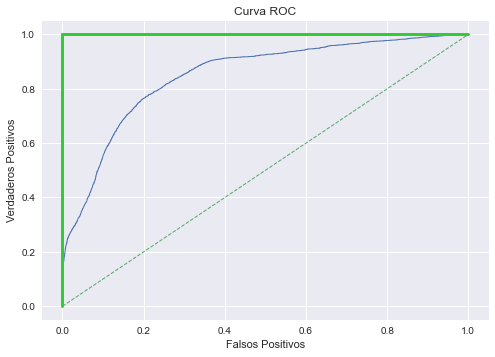

In [50]:
# Reestimamos los valores predichos de nuestro modelo para obtener la probabilidad entre 0 y 1.
yhat_p = default_model.predict_proba(X_test)[:, 1]
# generamos los objetos de roc_cruve
false_positive, true_positive, threshold = roc_curve(y_test, yhat_p)

# Plot ROC curve
plt.title('Curva ROC')
plt.plot(false_positive, true_positive, lw=1)
plt.plot([0, 1], ls="--", lw=1)
plt.plot([0, 0], [1, 0] , c='limegreen', lw=3), plt.plot([1, 1] ,
c='limegreen', lw=3)
plt.ylabel('Verdaderos Positivos')
plt.xlabel('Falsos Positivos');

In [51]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, yhat_p)

0.8496277512797533

## Modelo con datos estandarizados

In [52]:
ml_std_model = LogisticRegression().fit(X_train_2, y_train_2)
yhat_2 = ml_std_model.predict(X_test_2)
yhat_2[:20]

array([0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=uint8)

In [53]:
#métricas para el modelo estandarizado
m1_prec_2 = precision_score(y_test_2, yhat_2) 
m1_rec_2 = recall_score(y_test_2, yhat_2) 
print("Precision: ", m1_prec_2, "\nRecall: ", m1_rec_2)

Precision:  0.725705329153605 
Recall:  0.5981912144702842


__Interpretación__

>__Precisión:__ De todas las veces que el modelo __estandarizado__ dijo que el individuo ganaba más de 50 mil dólares, acertó el __72,57%__ de las veces
>
> __Recall:__ De todas las veces que el valor observado era un individuo con un salario mayor a 50 mil dólares, el modelo solo pudo acertar el __59,81%__ de las veces
>
> Podemos ver que el modelo con los datos estandarizados tiene mucho mejor rendimiento en este aspecto que el modelo no estandarizado en ambas métricas.

In [54]:
print(classification_report(y_test_2, yhat_2))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90     12248
           1       0.73      0.60      0.66      3870

    accuracy                           0.85     16118
   macro avg       0.80      0.76      0.78     16118
weighted avg       0.84      0.85      0.84     16118



Naturalmente al tener un dataset con mayor presencia de individuos que ganan por debajo del umbral, el modelo aprendió mejor a predecir cuando estos ganarán menos del umbral.


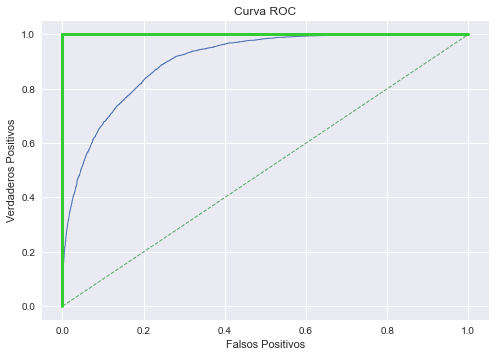

In [55]:
# reestimamos los valores predichos de nuestro modelo para obtener la probabilidad entre 0 y 1.
yhat_p_2 = ml_std_model.predict_proba(X_test_2)[:, 1]
# generamos los objetos de roc_cruve
false_positive, true_positive, threshold = roc_curve(y_test_2, yhat_p_2)

# Plot ROC curve
plt.title('Curva ROC')
plt.plot(false_positive, true_positive, lw=1)
plt.plot([0, 1], ls="--", lw=1)
plt.plot([0, 0], [1, 0] , c='limegreen', lw=3), plt.plot([1, 1] ,
c='limegreen', lw=3)
plt.ylabel('Verdaderos Positivos')
plt.xlabel('Falsos Positivos');

Se puede apreciar que la curva ROC muestra un mejor desempeño que la curva ROC con datos no estandarizados. También tenemos un área bajo la curva *AUC* Superior que en el modelo no estandarizado

In [56]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test_2, yhat_p_2)

0.9036835735033258